# Flux-Balance Analysis (FBA)
Flux Balance Analysis (FBA) is a mathematical approach used to analyze the flow of metabolites through a metabolic network. This method is based on the principle of steady-state balance, assuming that the concentration of internal metabolites in the system remains constant over time. 

Further reading on the fundamentals of FBA could be found [here](https://www.nature.com/articles/nbt.1614)


In this session we will follow the examples by Daniel Segre in the Notebook. The complete tutorials and examples could be found [here](https://colab.research.google.com/drive/1quuXRdXa92W3os9oT8aC6N31Pjl-Dhi9?usp=sharing#scrollTo=iRH3cKQ9C_wF)

In [1]:
import numpy as np # Imports Python numerical library
import seaborn as sns # Imports Library for drawing heatmaps
import matplotlib.pyplot as plt # Import Library for plotting graphs
from scipy.optimize import linprog # Imports Linear Programming function
from scipy.optimize import linprog_verbose_callback # Imports Linear Programming function

STOICHIOMETRIC MATRIX


<Axes: >

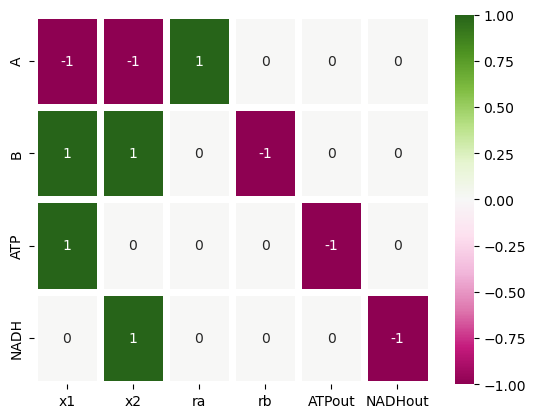

In [2]:
# labels of reactions
reacs = ['x1', 'x2', 'ra', 'rb', 'ATPout', 'NADHout']

# labels of metabolites
metabs = ['A', 'B', 'ATP', 'NADH']

n = len(reacs) # number of reactions
m = len(metabs) # number of metabolites

# define the stoichiometric matrix

S = np.array([[-1, -1, 1, 0, 0, 0],    # metab A
              [ 1,  1, 0, -1, 0, 0],    # metab B
              [ 1,  0, 0, 0, -1, 0],     # metab ATP
              [ 0,  1, 0, 0, 0, -1]])   # metab NADH

print('STOICHIOMETRIC MATRIX')
colormap = sns.color_palette('Greens')
sns.heatmap(S, annot=True, linewidth = 5, xticklabels=reacs, yticklabels=metabs, cmap = 'PiYG')

## Define optimization parameters
This includes flux lower bounds (LB), upper bounds(UB), and an objective function

In [3]:
b = np.zeros(m) # right-hand side of Sv=0
obj = np.zeros(n) # Initialize the objective function vector (the thing we are trying to minimize)

LARGE = 1000
LB = np.zeros(n)
UB = LARGE * np.ones(n)

# change flow throug individual reaction
UB[2] = 0.9

LBUB = np.transpose(np.stack((LB,UB), axis=0)) # Combine LB, UB into set of pairs [LB, UB]

obj[0] = -1 # default of optimizer (linprog) is to minimize, so a -1 will lead to maximazation
obj[1] = -1

## Run LP to solve FBA
Perform Linear Programming (LP) calculation

In [4]:
print("IMPLEMENT OPTIMIZATION")
# options
solution=linprog(c=obj, A_eq=S, b_eq=b, bounds=LBUB)
solution

print(f"optimal value: {solution.fun}")
print(f"solution vector: {solution.x}")

IMPLEMENT OPTIMIZATION
optimal value: -0.9
solution vector: [ 0.9  0.   0.9  0.9  0.9 -0. ]


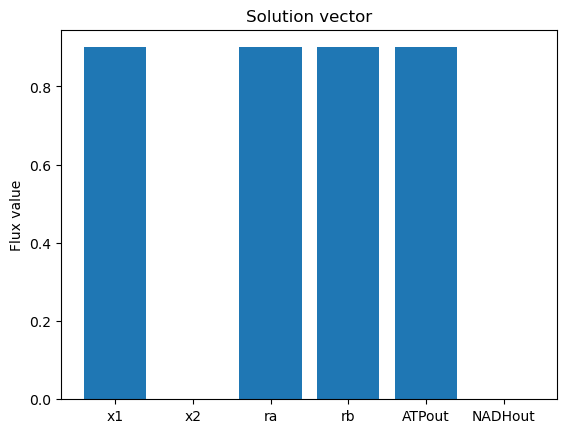

In [5]:
v_pos = np.arange(n)
plt.bar(v_pos, solution.x, align = 'center')
plt.xticks(v_pos, reacs)
plt.ylabel('Flux value')
plt.title('Solution vector')
plt.show()


### Visualize Rection Network

In [6]:
def draw_network(_S,_reacs,_metabs,_solution):

  import networkx as nx
  flux_vec = _solution.x #  flux vector
  thickness_factor = 7
  norm_flux = thickness_factor*flux_vec /max(abs(flux_vec)) # Computes normalized flux vector for drawing network
  G = nx.DiGraph()
  G.add_nodes_from(_metabs)
  G.add_nodes_from(_reacs)
  for col in range(_S.shape[1]): 
    reac_string=_reacs[col] + "[Flux = "+ str(round(flux_vec[col],2)) + "] : "
    curr_col=_S[:, col]
    curr_col_pos= np.where(curr_col > 0)[0] 
    curr_col_neg= np.where(curr_col < 0)[0] 

    if len(curr_col_neg)>0:
      for f in curr_col_neg:
        G.add_edge(_metabs[f],_reacs[col],weight=norm_flux[col])    

    if len(curr_col_pos)>0:
      for f in curr_col_pos:
        G.add_edge(reacs[col],metabs[f],weight=norm_flux[col])

  # pos = nx.spring_layout(G,weight=0)
  pos = nx.kamada_kawai_layout(G,weight=0)
  # pos = nx.circular_layout(G)

  edges = G.edges()
  #colors = [G[u][v]['color'] for u,v in edges]
  weights = [G[u][v]['weight']+0.1 for u,v in edges]

  #nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)
  nx.draw(G, pos, with_labels=True,node_size = 700, node_color=[[0.4, 0.7, 0.9]],width=weights)

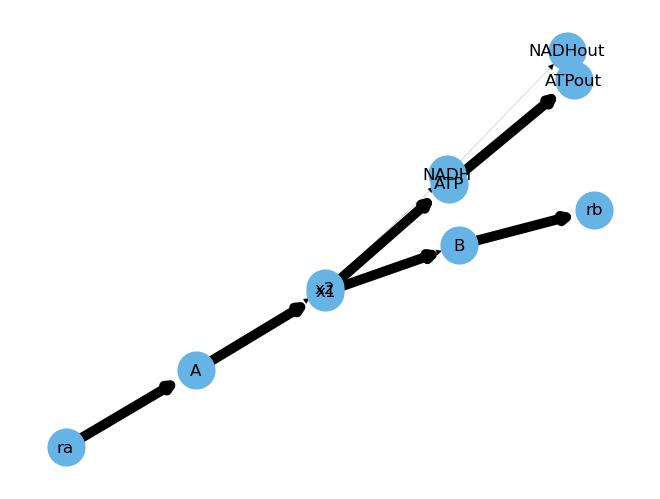

In [7]:
draw_network(S,reacs,metabs,solution)

### Check for essential vs non-essential genes

In [9]:
for i, reac in enumerate(reacs):
    # print(f"INDEX: {i}, REACTION: {reac}")

    # make the FBA problem
    b = np.zeros(m)  # right-hand side of Sv=0
    obj = np.zeros(n) # Initialize the objective function vector (the thing we are tring to minimize)
    LARGE = 1000 
    LB = np.zeros(n)
    UB = LARGE * np.ones(n)
    
    # turn this reaction off
    UB[i] = 0.0
    
    LBUB = np.transpose(np.stack((LB,UB), axis=0))  # combine LB, UB into set of pairs [LB, UB]
    
    obj[3] = -1  # default of optimizer (linprog) is to minimize, so a -1 will lead to maximization

    # solve the problem
    solution = linprog(c=obj, A_eq=S, b_eq=b, bounds=LBUB)

    if solution.fun == 0:
        print(f"REACTION {reac} is essential")
    else:
        print(f"REACTION {reac} is non-essential")
    # print(f"Optimal value: {solution.fun}")
    # print(f"KNOCKOUT REACTION {reac} Solution vector: {solution.x}")

REACTION x1 is non-essential
REACTION x2 is non-essential
REACTION ra is essential
REACTION rb is essential
REACTION ATPout is non-essential
REACTION NADHout is non-essential


## FBA with COBRA

In [10]:
import cobra
from cobra.io import load_model

# load the textbook model
model = load_model("textbook")

### Inspect the model cobra model

In [11]:
# This allows us to have a brief overview of the model
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


In [12]:
# get stoichiometric matrix
S = cobra.util.create_stoichiometric_matrix(model, "DataFrame")
# visualize stochiometric matrix

#plt.subplots(figsize=(30,20))
#sns.heatmap(S, annot=True, linewidth = .5, xticklabels=model.reactions, yticklabels=model.metabolites, cmap = 'PiYG')

In [13]:
# Get model reactions (Name, Reaction, Boundary)
#for r  in model.reactions:
    #print(f'{r.id}, {r.name}, {r.reaction}; [LB, UB] = [{r.lower_bound},{r.upper_bound}]')

In [14]:
# Run the model and get optimal value
solution = model.optimize()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94],
 [Text(0, 0, 'ACALD'),
  Text(1, 0, 'ACALDt'),
  Text(2, 0, 'ACKr'),
  Text(3, 0, 'ACONTa'),
  Text(4, 0, 'ACONTb'),
  Text(5, 0, 'ACt2r'),
  Text(6, 0, 'ADK1'),
  Text(7, 0, 'AKGDH'),
  Text(8, 0, 'AKGt2r'),
  Text(9, 0, 'ALCD2x'),
  Text(10, 0, 'ATPM'),
  Text(11, 0, 'ATPS4r'),
  Text(12, 0, 'Biomass_Ecoli_core'),
  Text(13, 0, 'CO2t'),
  Text(14, 0, 'CS'),
  Text(15, 0, 'CYTBD'),
  Text(16, 0, 'D_LACt2'),
  Text(17, 0, 'ENO'),
  Tex

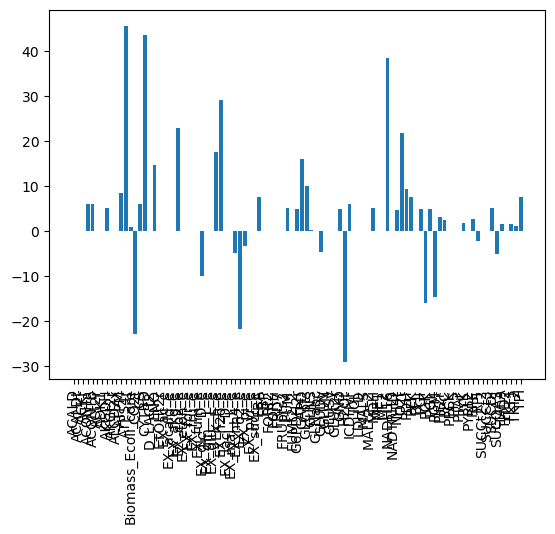

In [15]:
# plot the results for optimal values

fluxes = solution.fluxes
reac_names = [r.id for r in model.reactions]
fig = plt.figure()
plt.bar(reac_names, fluxes)
plt.xticks(rotation=90)


### Investigate Growth rate at varying oxygen levels

In [16]:
n_points = 20
o2vec = np.linspace(0,40,n_points)
vgro = np.zeros(o2vec.size) ## initialize vector of growth rates
vacet=np.zeros(o2vec.size)
original_lb = model.reactions.EX_o2_e.lower_bound # original upper bound

for index, o2_level in enumerate(o2vec):
    model.reactions.EX_o2_e.lower_bound = - o2_level
    
    # run FBA
    solution = model.optimize()
    vgro[index] = solution.objective_value
    vacet[index] = solution.fluxes.EX_ac_e

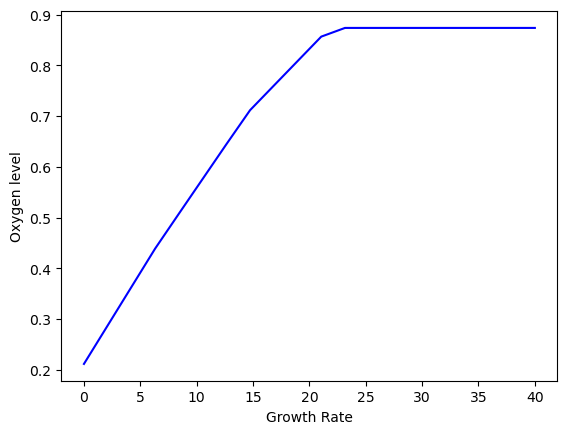

In [17]:
# plot
plt.plot(o2vec, vgro,'b')
plt.xlabel('Growth Rate')
plt.ylabel('Oxygen level')
plt.show()

### Effect of varying oxygen of acetate levels

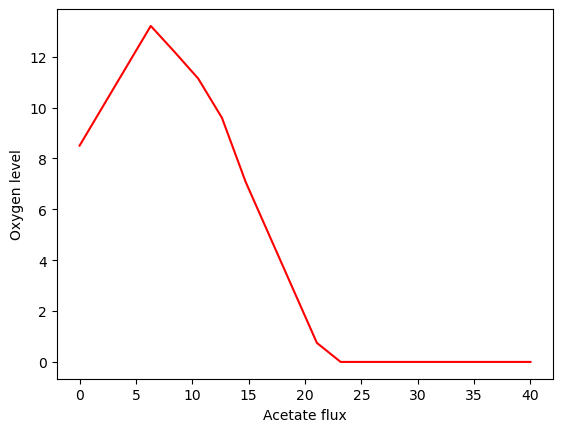

In [18]:
# plot acetate
plt.plot(o2vec, vacet,'r')
plt.xlabel('Acetate flux')
plt.ylabel('Oxygen level')
plt.show()

In [19]:
# get all exchange reactions based on their id, assuming they all start with EX_

exchange_reactions_ids = []
for r in model.reactions:
    r_id = r.id
    if 'EX_' in r_id:
        exchange_reactions_ids.append(r_id)

### Effect of different oxygen level on different exchange reactions

In [22]:
import copy
n_points = 20
original_lb = -1000
O2vec = np.linspace(0,40, n_points)                # vectore of o2 levels
vgro = np.zeros(O2vec.size)                        # initalize vector of growth rates
model.reactions.EX_o2_e.lower_bound = original_lb  # set the baseline o2 bound
exchange_fluxes = {
    r_id: np.zeros(O2vec.size) 
    for r_id in exchange_reactions_ids
}

# go through each o2 level and get solution
for index, o2_level in enumerate(O2vec):

    # change the environment according to o2 level
    model.reactions.EX_o2_e.lower_bound = - o2_level

    # run FBA
    solution = model.optimize()

    # save the solutions
    vgro[index] = solution.objective_value
    for r_id in exchange_reactions_ids:
        exchange_fluxes[r_id][index] = solution.fluxes[r_id]

# return model to original bounds
model.reactions.EX_o2_e.lower_bound = original_lb

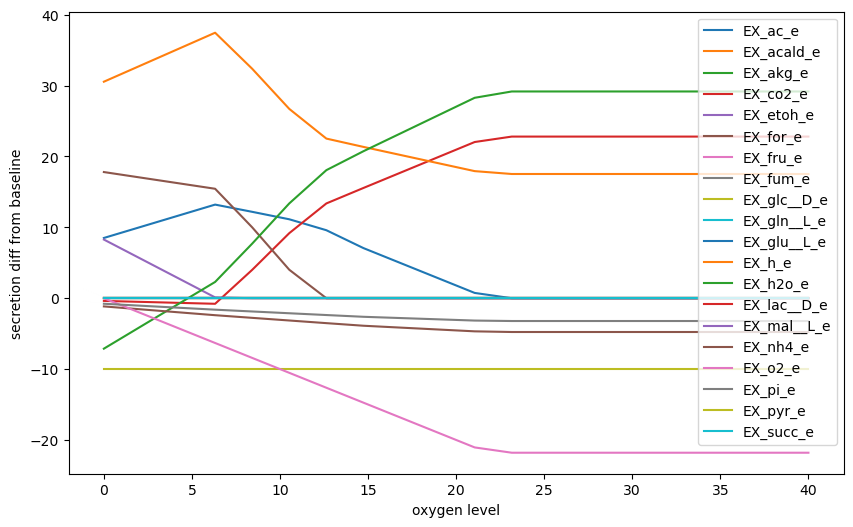

In [23]:
# plot
plt.figure(figsize=(10, 6)) 
ax = plt.subplot(111)
for r_id in exchange_reactions_ids:
    ax.plot(O2vec,exchange_fluxes[r_id], label=r_id)
ax.set_ylabel('secretion diff from baseline')
ax.set_xlabel('oxygen level')
ax.legend()